# Homework 4

## Mysql-Python Connection

In [1]:
import mysql.connector
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import csv

%matplotlib inline

In [2]:
db_connection = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="wwdc2019", # change password
  auth_plugin='mysql_native_password'
)
print(db_connection)

In [3]:
# creating database_cursor to perform SQL operation to run queries
db_cursor = db_connection.cursor(buffered=True)

# executing cursor with execute method and pass SQL query
#db_cursor.execute("CREATE DATABASE ps_ecommerce")

# get list of all databases
db_cursor.execute("SHOW DATABASES")

# print all databases
for db in db_cursor:
    print(db)
    
db_cursor.execute("USE ps_ecommerce")

('information_schema',)
('mysql',)
('performance_schema',)
('ps_ecommerce',)
('sys',)
('world',)


## Load Data to Mysql Tables

In [8]:
def populate_table(db_connection, db_cursor, insert_query, file_path):
    
    with open(file_path, mode='r') as csv_data:
        reader = csv.reader(csv_data, delimiter=';')
        csv_data_list = list(reader)
        for row in csv_data_list[1:]:
            row = tuple(map(lambda x: None if x == "" else x, row[0].split(',')))
            db_cursor.execute(insert_query, row)
        
    db_connection.commit()

In [9]:
# create CUSTOMERS table
'''db_cursor.execute("""CREATE TABLE CUSTOMERS (customer_id VARCHAR(50) NOT NULL, 
                                          customer_unique_id VARCHAR(50) NOT NULL, 
                                          customer_zip_code_prefix VARCHAR(50), 
                                          customer_city VARCHAR(50), 
                                          customer_state VARCHAR(50))""")'''

insert_customers = (
    "INSERT INTO CUSTOMERS(customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state) "
    "VALUES (%s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_customers, "customers.csv")

In [10]:
# create ORDER_PAYMENTS table
db_cursor.execute("""CREATE TABLE ORDER_PAYMENTS (order_id VARCHAR(50) NOT NULL, 
                                          payment_sequential INTEGER, 
                                          payment_type VARCHAR(50), 
                                          payment_installments INTEGER, 
                                          payment_value FLOAT)""")

insert_orderpayments = (
    "INSERT INTO ORDER_PAYMENTS(order_id, payment_sequential, payment_type, payment_installments, payment_value) "
    "VALUES (%s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orderpayments, "order_payments.csv")

In [11]:
# create ORDER_ITEMS table
db_cursor.execute("""CREATE TABLE ORDER_ITEMS (order_id VARCHAR(50) NOT NULL, 
                                          order_item_id INTEGER, 
                                          product_id VARCHAR(50), 
                                          seller_id VARCHAR(50), 
                                          shipping_limit_date DATETIME,
                                          price FLOAT,
                                          freight_value FLOAT)""")

insert_orderitems = (
    "INSERT INTO ORDER_ITEMS(order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orderitems, "order_items.csv")

In [12]:
# create ORDERS table
db_cursor.execute("""CREATE TABLE ORDERS (order_id VARCHAR(50) NOT NULL, 
                                          customer_id VARCHAR(50) NOT NULL, 
                                          order_status VARCHAR(50), 
                                          order_purchase_timestamp DATETIME, 
                                          order_approved_at DATETIME,
                                          order_delivered_carrier_date DATETIME,
                                          order_delivered_customer_date DATETIME,
                                          order_estimated_delivery_date DATETIME)""")

insert_orders = (
    "INSERT INTO ORDERS(order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orders, "orders.csv")

## Question 1 (10 pts)

In [4]:
# Find the average number of weeks between products' actual delivery dates and estimated delivery dates. 
# Use order_delivered_customer_date column as actual delivery dates and 
# order_estimated_delivery_date column as estimated delivery dates.

# HINT: There is a function in MySQL that makes it easy to compute the difference between two timestamps.
# We recommend that you search for it online and use it in your answer.

In [5]:
# Solve Question 1 below
db_cursor.execute("""
                    SELECT AVG(TIMESTAMPDIFF(WEEK,O.order_delivered_customer_date, o.order_estimated_delivery_date))
                    FROM ORDERS O;
                  """)
average_weeks_query = db_cursor.fetchall()

In [6]:
float(average_weeks_query[0][0])

1.1862

## Question 2 (15 pts)

In [7]:
# Consider the ORDER_COSTS table below. Using this table and the CUSTOMERS table, find the following:
# In which states do customers spend, on average, more than 164 on their orders? 
# Fetch those states and average order costs in those states. Results should be ordered from lowest cost to highest.

In [8]:
order_costs_query = """
                    CREATE TABLE ORDER_COSTS AS (
                        SELECT ORDERS.order_id, SUM(price) AS cost, ORDERS.customer_id as cid
                        FROM ORDER_ITEMS 
                             JOIN ORDERS
                             ON ORDER_ITEMS.order_id=ORDERS.order_id
                        GROUP BY order_id, ORDERS.customer_id)
                    """

db_cursor.execute(order_costs_query)

ProgrammingError: 1050 (42S01): Table 'ORDER_COSTS' already exists

In [9]:
# Solve Question 2 below
db_cursor.execute("""
                    SELECT c.customer_state, AVG(oc.cost)
                    FROM ORDER_COSTS oc, CUSTOMERS c
                    WHERE   oc.cid=c.customer_id
                    GROUP BY c.customer_state
                    HAVING AVG(oc.cost)>164
                    ORDER BY AVG(oc.cost) ASC
                  """)
average_order_costs_query = db_cursor.fetchall()

In [10]:
average_order_costs_query

[('PE', 165.95715586927687),
 ('RN', 168.72618171229507),
 ('MS', 173.50979253761005),
 ('TO', 179.9429249493581),
 ('PA', 182.85564198849806),
 ('MT', 184.82068734097837),
 ('AL', 202.31006200565315),
 ('RO', 217.85388387291178),
 ('PB', 222.1680950891404),
 ('AC', 224.56719970703125),
 ('RR', 279.38705960442036)]

## Question 3 (15 pts)

In [11]:
# Implement the following function get_month. It takes as input a month as an integer.
# It needs to compute: In the given month, how many payments were made with each different payment type?
# e.g.: Credit card -> 5000 payments, debit card -> 100 payments, voucher -> 300 payments, ...

# HINT: One of the MySQL functions we covered in the PS makes it easy to work with months.

In [12]:
# Solve Question 3 below

def get_month(month):
    
    query = f"""SELECT DISTINCT op.payment_type, COUNT(*) 
    FROM ORDER_PAYMENTS op, ORDERS o 
    WHERE op.order_id=o.order_id AND MONTH(o.order_purchase_timestamp)={month} 
    GROUP BY op.payment_type"""
    
    
    db_cursor.execute(query)
    items = db_cursor.fetchall()
    result = ""
    for i in range(len(items)):
        result += items[i][0] + " -> " + str(items[i][1]) + "\n"
    return result

In [13]:
# Here is a sample function call for get_month:
print(get_month("2"))

credit_card -> 6609
boleto -> 1723
voucher -> 424
debit_card -> 82



## Question 4 (10 pts)

In [14]:
# Consider the PRODUCTS table below and the ORDER_ITEMS table from earlier. 
# For each product category other than {"moveis_decoracao", "beleza_saude"}, find the minimum price that was paid for
# an item from that category. Limit the result to retrieve only 6 rows.

# The result should be like: category1 -> minprice1, category2 -> minprice2, ...

In [15]:
'''db_cursor.execute("""CREATE TABLE PRODUCTS (product_id VARCHAR(50) NOT NULL, 
                                            product_category_name VARCHAR(50), 
                                            product_name_lenght INTEGER, 
                                            product_description_lenght INTEGER, 
                                            product_photos_qty INTEGER,
                                            product_weight_g INTEGER,
                                            product_length_cm INTEGER,
                                            product_height_cm INTEGER,
                                            product_width_cm INTEGER)""")'''

insert_products = (
    "INSERT INTO PRODUCTS(product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm,  product_height_cm, product_width_cm) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_products, "products.csv")

NameError: name 'populate_table' is not defined

In [16]:
# Solve Question 4 below
db_cursor.execute("""
                    SELECT p.product_category_name ,MIN(oi.price)
FROM PRODUCTS p, ORDER_ITEMS oi
WHERE p.product_id=oi.product_id
GROUP BY p.product_category_name
HAVING p.product_category_name!='moveis_decoracao' AND p.product_category_name!='beleza_saude'
LIMIT 6
                  """)
mpec = db_cursor.fetchall()
category_name, min_price = map(list, zip(*mpec))
mpec_result = ""
for i in range(len(mpec)):
    mpec_result += mpec[i][0] + " -> " + str(mpec[i][1]) + "\n"

In [17]:
print(mpec_result)

esporte_lazer -> 5.49
utilidades_domesticas -> 4.4
cama_mesa_banho -> 6.99
informatica_acessorios -> 3.9
relogios_presentes -> 8.99
brinquedos -> 4.99



## Question 5 (10 pts)

In [18]:
# Draw a pie chart using the data from the previous question.
# Labels of your pie chart should be the product categories.
# Contents of your pie chart (i.e., sizes of the pie slices) should be determined by the min prices.

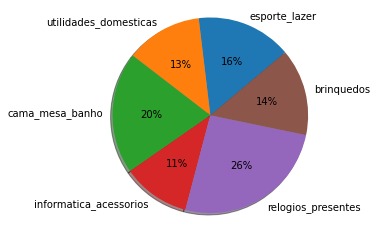

In [19]:
# Solve Question 5 below
fig1, ax1 = plt.subplots()
ax1.pie(min_price, labels=category_name, autopct='%1.0f%%', shadow=True, startangle=40)
ax1.axis('equal') 
plt.show()

## Question 6 (15 pts)

In [20]:
# Let us define "large products" as those products with weight > 400 and length > 10.
# Some orders that contain a large product can have large discrepancies between their order_delivered_carrier_date and 
# order_delivered_customer_date. 
# Let us define "strange orders that contain large products" as those orders which contain a large product and the 
# difference between their order_delivered_carrier_date and order_delivered_customer_date is larger than 100 days.

# For all "strange orders that contain large products", find their order IDs and the number of days difference between 
# their order_delivered_carrier_date and order_delivered_customer_date.
# Result should be like: "abc21312df" -> 32, "dhs230kdf8" -> 29, ...

# HINT: Using the same MySQL function as Question 1 may help.

In [21]:
# Solve Question 6 below
db_cursor.execute("""
                    SELECT o.order_id, TIMESTAMPDIFF(DAY, o.order_delivered_carrier_date, o.order_delivered_customer_date)
                    FROM PRODUCTS p, ORDERS o, ORDER_ITEMS oi
                    WHERE p.product_weight_g>400 AND p.product_length_cm>10 AND
                    TIMESTAMPDIFF(DAY, o.order_delivered_carrier_date, o.order_delivered_customer_date)>100 
                    AND p.product_id=oi.product_id AND o.order_id=oi.order_id
                  """)
laso = db_cursor.fetchall()
order_id, day_diff = map(list, zip(*laso))
laso_result = ""
for i in range(len(laso)):
    laso_result += laso[i][0] + " -> " + str(laso[i][1]) + "\n"

In [22]:
print(laso_result)

6e3a1f3ec46461756c3f620e267aa1b8 -> 103
d24e8541128cea179a11a65176e0a96f -> 171
3b919fbc512d96f81330d2aae3ed0cf6 -> 106
0f4519c5f1c541ddec9f21b3bddd533a -> 181
e52c9dfec957c503bed5d050a39c740f -> 102
031e7d4e559a1bf08e71a419aa998d0a -> 165
437222e3fd1b07396f1d9ba8c15fba59 -> 182
525e11b26fdb7f41471d289897d0f6da -> 167
47b40429ed8cce3aee9199792275433f -> 157
1b3190b2dfa9d789e1f14c05b647a14a -> 205
2ba1366baecad3c3536f27546d129017 -> 178
dfe5f68118c2576143240b8d78e5940a -> 181
0b32bf55276b5feb681f6ed6fd670692 -> 143
d8dbb44d7c5b1fd8e7f41b49e27053d7 -> 104
cce224811ba8fea016c049693c3e0402 -> 145
6e82dcfb5eada6283dba34f164e636f5 -> 180
160d1364f477494647a995f6bbec0b5f -> 104
7e708aed151d6a8601ce8f2eaa712bf4 -> 134
a4efaffc506a395c9cea7402b078c1e5 -> 103



## Question 7 (10 pts)

In [23]:
# Draw a bar chart using the data from the previous question.
# Order IDs should be on the x-axis.
# Number of days difference should be on the y-axis.
# (Although we are not looking for production quality figures, make sure that your plots are readable.)

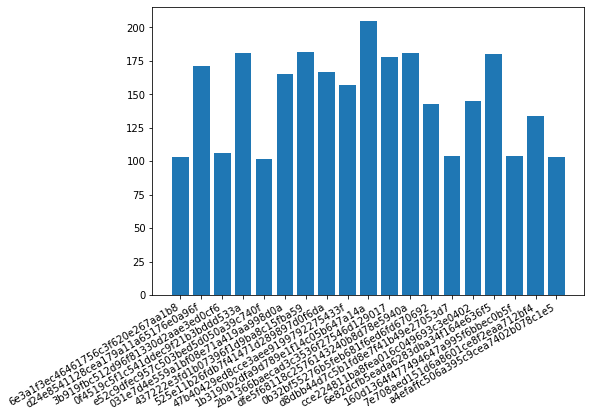

In [24]:
# Solve Question 7 below
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(order_id, day_diff)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

## Question 8 (15 pts)

In [25]:
# Write an SQL query to find the total number of orders per week day, e.g., Monday -> 150 orders, Tuesday -> 200 orders,
# Wednesday -> 500 orders, etc. Use the "order_purchase_timestamp" attribute when counting the number of orders.
# Plot the result using a bar chart (days of week on x-axis, number of orders on y-axis). 

# HINT: Check out the "WEEKDAY" function of MySQL. 

In [26]:
# Solve Question 8 below
db_cursor.execute("""
                    SELECT WEEKDAY(o.order_purchase_timestamp), COUNT(*)
FROM ORDERS o
GROUP BY WEEKDAY(o.order_purchase_timestamp)
                  """)
order_number_each_day = db_cursor.fetchall()
weekday, order_number = map(list, zip(*order_number_each_day))
valuemap = {}
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(len(weekday)):
    valuemap[weekday[i]] = order_number[i]
valuemap = dict(sorted(valuemap.items(), key=lambda item: item[1]))
for i in range(len(valuemap)):
    valuemap[days[i]] = valuemap.pop(i)

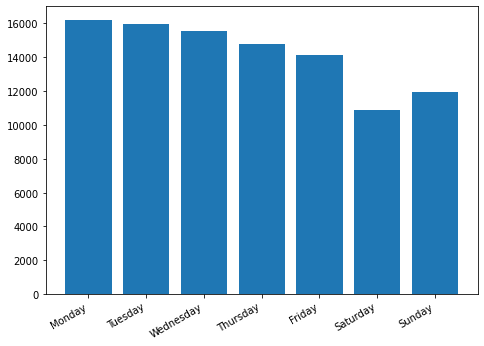

In [27]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(valuemap.keys()), list(valuemap.values()))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [28]:
db_cursor.close()
db_connection.close()